In [5]:
vlib = c("tidyverse", "ggpubr", "patchwork", "tidyseurat", "future.apply",
   "arrow", "pheatmap", "ggrastr",  "Seurat", "hdWGCNA", "ggsci", "ggrepel")
lapply(vlib, require, character.only = TRUE, quietly = TRUE) |> suppressMessages()

base_dir = "."
setwd(base_dir)

saveRDS.gz <- function(object, file, threads=4) {
  con <- pipe(paste0("pigz -p", threads, " > ", file), "wb")
  saveRDS(object, file = con)
  close(con)
}
readRDS.gz <- function(file, threads = parallel::detectCores()) {
  con <- pipe(paste0("pigz -d -c -p", threads, " ", file))
  object <- readRDS(file = con)
  close(con)
  return(object)
}

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] FALSE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] FALSE

[[8]]
[1] FALSE

[[9]]
[1] FALSE

[[10]]
[1] FALSE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

In [ ]:
seurat_obj.ref = readRDS.gz("seuratobj.wgcna.RDS")

In [ ]:
seurat_obj.ref <- SetDatExpr(
  seurat_obj.ref,
  group_name = "CD8",
  group.by = "anno_l1"
)

## AIDA dataset

In [ ]:
seurat_obj.aida = readRDS.gz("seuratobj.aida.RDS")
DefaultAssay(seurat_obj.aida) = "RNA"

In [ ]:
seurat_obj.aida <- ProjectModules(
  seurat_obj = seurat_obj.aida,
  seurat_ref = seurat_obj.ref,
  # vars.to.regress = c(), # optionally regress covariates when running ScaleData
  group.by.vars = "ID", # column in seurat_query to run harmony on
  wgcna_name_proj="wgcna_repl_cd8", # name of the new hdWGCNA experiment in the query dataset
  wgcna_name = "wgcna" # name of the hdWGCNA experiment in the ref dataset
)

seurat_obj.aida <- SetDatExpr(
  seurat_obj.aida,
  group_name = "CD8 T",
  group.by = "predicted.celltype.l1"
)

seurat_obj.aida <- ModulePreservation(
  seurat_obj.aida,
  seurat_ref = seurat_obj.ref,
  name="wgcna_repl_cd8",
  verbose=3,
  n_permutations=250 # n_permutations=20 used for the tutorial
)

In [ ]:
mod_pres <- GetModulePreservation(seurat_obj.aida, "wgcna_repl_cd8")$Z # z-scored
mod_pres = mod_pres %>% select(-8) %>% rownames_to_column("color") %>% write_delim("assets/wgcna/replication_modpres.txt.gz", delim = "\t")
obs_df <- GetModulePreservation(seurat_obj.aida, "wgcna_repl_cd8")$obs # observed
obs_df %>% select(-8) %>% rownames_to_column("color") %>% write_delim("assets/wgcna/replication_obsdf.txt.gz", delim = "\t")

In [2]:
mod_pres = read_delim("assets/wgcna/replication_modpres.txt.gz", delim = "\t")

Rows: 12 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): color
dbl (20): moduleSize, Zsummary.qual, Z.propVarExplained.qual, Z.meanSignAwar...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## supplementary figure F6a

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 200)
pmod_pres = mod_pres %>%
  dplyr::select(1,2, Zsummary.pres, Zsummary.qual) %>%
  pivot_longer(col = 3:ncol(.)) %>%
  ggplot(aes(x = moduleSize, y = value, fill = color)) +
    geom_rect(aes(xmin=-Inf, xmax=Inf, ymin=-Inf, ymax=2), fill = "grey50", alpha = 0.4)+
    geom_rect(aes(xmin=-Inf, xmax=Inf, ymin=2, ymax=10), fill = "grey80", alpha = 0.4)+
    geom_hline(yintercept = 0)+
    geom_point(shape = 21,size = 3)+
    scale_fill_identity()+
    geom_text_repel(aes(label = color))+
    theme_pubr(legend = "right")+
    facet_wrap(~name, scale = "free") +
    theme(axis.line = element_blank(),
          axis.text = element_text(size = 14),
          axis.title = element_text(size = 15),
          panel.border = element_rect(fill = NA),
          strip.background = element_rect(fill= NA),
          strip.text = element_text(size = 13)
          )
pmod_pres
pmod_pres %>% ggsave(
  "figure_prep/supplementary/sf6_modpres.pdf",
  ., height = 5, width = 8, dpi = 300
)

## TME dataset

In [ ]:
seurat_obj.tme = readRDS.gz("seuratobj.tme.RDS")
DefaultAssay(seurat_obj.tme) = "RNA"

In [ ]:
seurat_obj.tme <- ProjectModules(
  seurat_obj = seurat_obj.tme,
  seurat_ref = seurat_obj.ref,
  # vars.to.regress = c(), # optionally regress covariates when running ScaleData
  group.by.vars = "ID", # column in seurat_query to run harmony on
  wgcna_name_proj="projection", # name of the new hdWGCNA experiment in the query dataset
  wgcna_name = "wgcna" # name of the hdWGCNA experiment in the ref dataset
)

seurat_obj.tme <- SetDatExpr(
  seurat_obj.tme,
  group_name = "CD8_T",
  group.by = "anno_l1"
)

In [ ]:
seurat_obj.tme <- ModulePreservation(
  seurat_obj.tme,
  seurat_ref = seurat_obj.ref,
  name="wgcna_preservation",
  verbose=3,
  n_permutations=250 # n_permutations=20 used for the tutorial
)

In [ ]:
mod_pres <- GetModulePreservation(seurat_obj.tme, "wgcna_preservation")$Z # z-scored
mod_pres = mod_pres %>% select(-8) %>% rownames_to_column("color") %>% write_delim("assets/tme_analysis/replication_modpres.txt.gz", delim = "\t")
obs_df <- GetModulePreservation(seurat_obj.tme, "wgcna_preservation")$obs # observed
obs_df %>% select(-8) %>% rownames_to_column("color") %>% write_delim("assets/tme_analysis/replication_obsdf.txt.gz", delim = "\t")

In [3]:
mod_pres = read_delim("assets/tme_analysis/replication_modpres.txt.gz", delim = "\t")

Rows: 12 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): color
dbl (20): moduleSize, Zsummary.qual, Z.propVarExplained.qual, Z.meanSignAwar...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


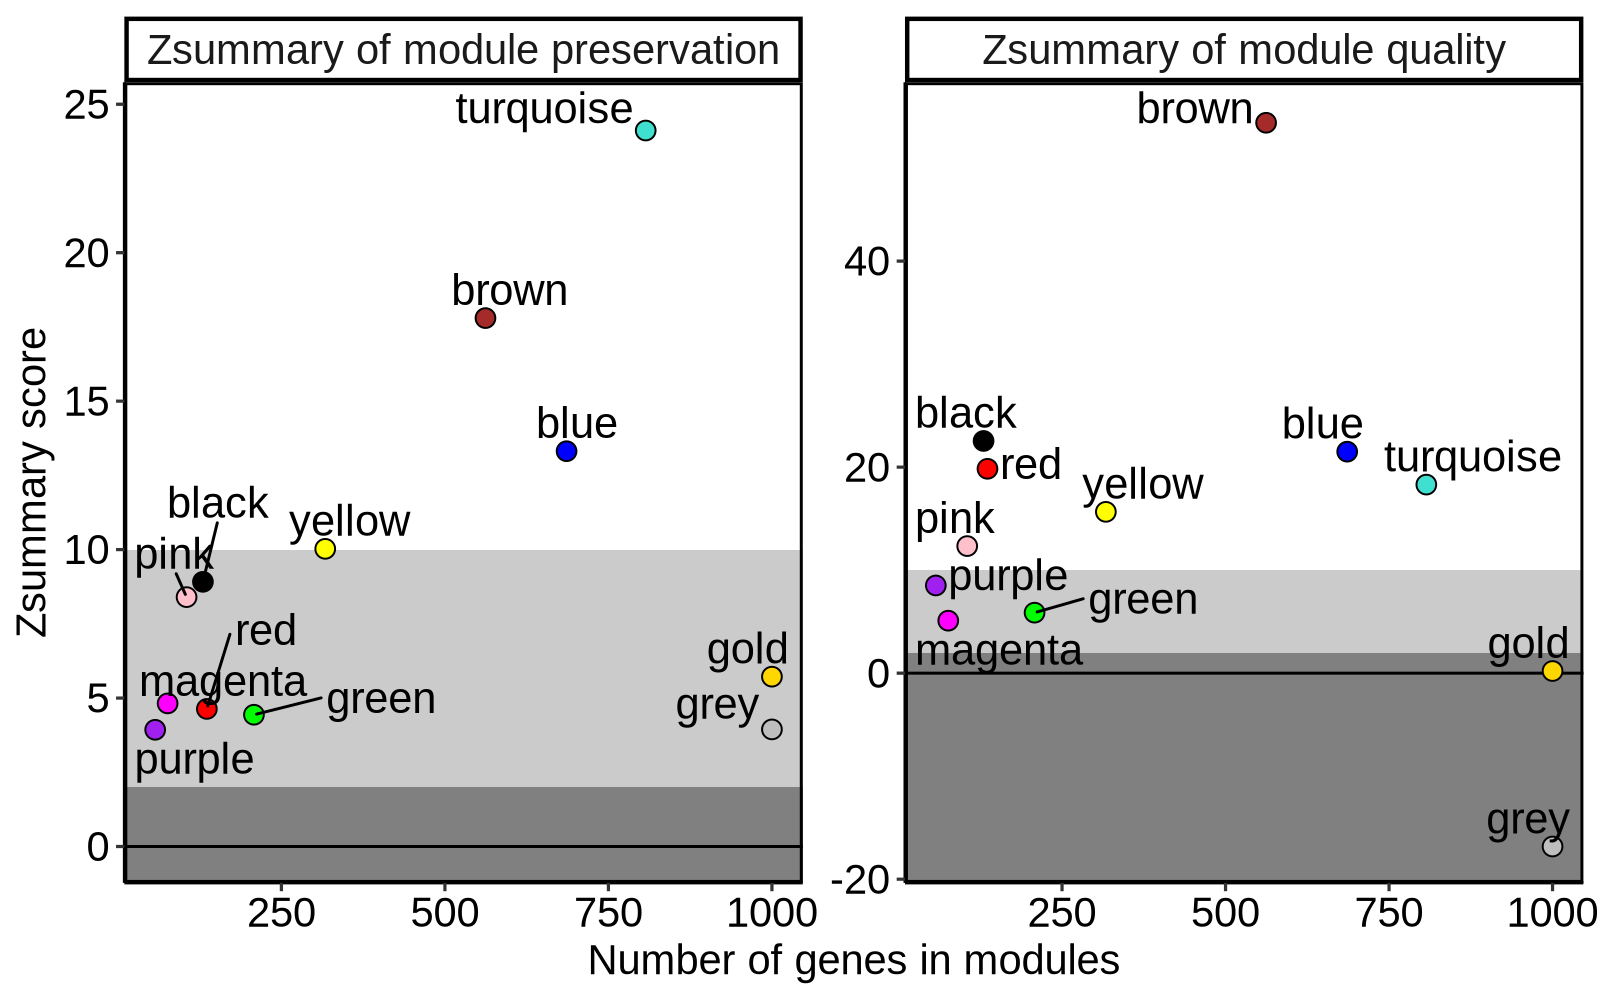

In [22]:
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 200)
pmod_pres = mod_pres %>%
  dplyr::select(1,2, Zsummary.pres, Zsummary.qual) %>%
  pivot_longer(col = 3:ncol(.)) %>%
  mutate(name = ifelse(name == "Zsummary.pres", "Zsummary of module preservation", "Zsummary of module quality")) %>%
  ggplot(aes(x = moduleSize, y = value, fill = color)) +
    geom_rect(aes(xmin=-Inf, xmax=Inf, ymin=-Inf, ymax=2), fill = "grey50", alpha = 0.4)+
    geom_rect(aes(xmin=-Inf, xmax=Inf, ymin=2, ymax=10), fill = "grey80", alpha = 0.4)+
    geom_hline(yintercept = 0)+
    geom_point(shape = 21,size = 3)+
    scale_fill_identity()+
    geom_text_repel(aes(label = color), size = 5.5,nudge_y = 0.4)+
    theme_pubr(legend = "right")+
    xlab("Number of genes in modules")+
    ylab("Zsummary score")+
    facet_wrap(~name, scale = "free") +
    theme(
          axis.text = element_text(size = 15),
          axis.title = element_text(size = 15),
          panel.border = element_rect(fill = NA, color = "black", linewidth = 1),
          strip.background = element_rect(fill= NA, linewidth = 1.5),
          strip.text = element_text(size = 15)
          )
pmod_pres
pmod_pres %>% ggsave(
  "figure_prep/sf9_tme_modpres.pdf",
  ., height = 5, width = 8, dpi = 300
)